# Character Building
People say that doing difficult stuff builds character, so lets try to do something really horrible and difficult: automatically extracting character lists from novels. Doing that will allow us to build our graphs from raw books without any prior knowledge of what they contain.

First we need to import all the usual junk

In [1]:
import utils
from utils import *

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12,9)

import pandas as pd
import numpy as np
import networkx as nx
import spacy

import json
import string

Now we can load in a book and split it into sentences...

In [3]:
book = load_book('../data/raw/fellowship_of_the_ring.txt', lower=False)
sequences = get_sentence_sequences(book)

### Name Extraction
This first naive solution uses a little bit of creativity and a whole load of brute-force.  
A sensible place to start when looking for character names is to go and find _proper nouns_. Part-of-speech tagging is a pretty simple NLP technique which does just that - it assigns a tag to each word in a string according to its _type_ - noun, verb, adverb etc ([you can read more about part-of-speech tagging here](https://en.wikipedia.org/wiki/Part-of-speech_tagging)). [Spacy](https://spacy.io/) has a pretty good POS tagger - having messed around with both Spacy and NLTK, I can say that with confidence that Spacy's is currently the more adept tagger. 
If we run this over the whole book and grab everything tagged as `'PROPN'` we'll return a list of plausible proper nouns. This could take a while, given that we have this many individual words to interpret and tag:

In [4]:
len(book.split())

188116

It makes more sense to start with a stripped down list of the _unique_ words which appear in the text. That way, we only have to tag each word once. We should also get strip out all punctuation from the words before we start.

In [5]:
remove_punctuation = lambda s: s.translate(str.maketrans('', '', string.punctuation+'’'))
words = [remove_punctuation(p) for p in book.split()]

unique_words = list(set(words))
len(unique_words)

10531

Now we can grab those `'PROPN'` tagged words

In [6]:
nlp = spacy.load('en')

propernouns = [word.text for word in nlp(' '.join(unique_words)) if word.pos_ == 'PROPN']
len(propernouns)

1339

It's unlikely that our English-language books will include characters whose names are shorter than 3 characters. We should get rid of those...

In [7]:
propernouns = [p for p in propernouns if len(p) > 3]
len(propernouns)

1216

I've noticed that Spacy will occasionally tag non-title-case words as proper nouns, which is odd. Character names will typically be capitalised so we'll get rid of anything which isn't. We're relying on authors' 'proper' use of English language conventions here, which aren't always going to be perfect, but that's part of the joy of this project; we can still make a decent approximation of the truth despite the messiness of the initial data.

In [8]:
propernouns = [p for p in propernouns if p.istitle()]
len(propernouns)

1150

I've also noticed that when dealing with characters in so many contexts, we'll sometimes get characters appearing as themselves and as posessives (ie `Frodo` and `Frodo's`). After stripping out punctuation we'll see `Frodo` and `Frodos`, so we just have to get rid of those words which end in `s` but are otherwise duplicates of other words already in the list.

In [9]:
propernouns = [p for p in propernouns if not (p[-1] == 's' and p[:-1] in propernouns)]
len(propernouns)

1063

NLTK includes a load of _stop words_ which we can compare our list against. Stop words are commonly occurring English words like 'the' or 'in' which are very unlikely to overlap with our characters' names. Strip them out...

In [10]:
stopwords = nltk.corpus.stopwords.words('english')

propernouns = list(set([p.title() for p in [p.lower() for p in propernouns]]) - set(stopwords))

len(propernouns)

1063

In [11]:
propernouns[:10]

['Isen',
 'Common',
 'Cnrdan',
 'Goodbody',
 'Apple',
 'Dear',
 'Northward',
 'Arvernien',
 'Yjni',
 'Nicotiana']

All that remains to be done is to get them into the usual form that bookworm expects (a list of tuples). We'll call this our list of characters.

In [12]:
characters = [tuple([character + ' ']) for character in set(propernouns)]

Obviously this is a _significantly_ longer list than what we usually deal with when we list characters manually, and it's a lot less precise (fore- and surnames won't be connected, nicknames won't be attached to their characters etc), but it's a pretty good trade-off for the lack of required contextual knowledge before starting the analysis. You'll also notice that a few 'names' aren't actually names - they're words that have somehow managed to slip through the gauntlet. As we move into the typical bookworm analysis process below, we'll see that this doesn't significantly affect the final results.

# Standard Analysis & Comparisons to Manual Character Assignation
We can now throw our list of automatically collected characters and our usual sequences into the usual bookworm analysis process. Set up our hash tables, find connections between characters and sequences, then connections between characters and characters, and finally set up our interaction dataframe which we'll pass to NetworkX to visualise.  
Because we're now dealing with a much longer list of characters, the computation will take a lot longer to run. The coocurrence calculation is a tough one if it's not being run on a GPU, and there are _a lot_ of lookups involved in the construction of the `interaction_df`. It should all still run comfortably on a decent laptop though.

In [13]:
hash_to_sequence, sequence_to_hash = get_sequence_hashes(sequences)
hash_to_character, character_to_hash = get_character_hashes(characters)

df = find_connections(sequences, characters)

cooccurence = calculate_cooccurence(df)

In [14]:
interaction_df = pd.DataFrame([[str(c1), 
                                str(c2), 
                                cooccurence[hash(c1)][hash(c2)]]
                               for c1 in characters
                               for c2 in characters],
                              columns=['source', 'target', 'value'])

In [15]:
interaction_df.sample(5)

,source,target,value
160414,"('Galadriel ',)","('Gently ',)",0
236461,"('Cheers ',)","('Barliman ',)",0
189179,"('Order ',)","('Mistress ',)",0
173576,"('Aragorn ',)","('Edrendil ',)",0
399819,"('Forsaken ',)","('Grief ',)",0


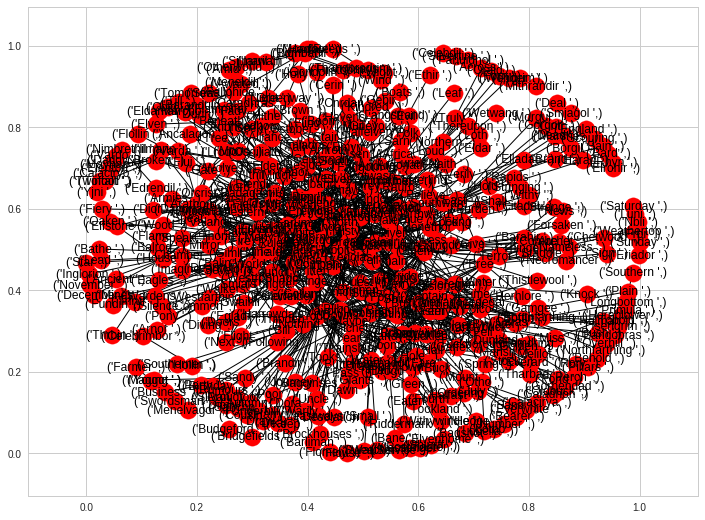

In [16]:
G = nx.from_pandas_dataframe(interaction_df[interaction_df['value'] > 0],
                             source='source',
                             target='target')

nx.draw_networkx(G, with_labels=True)

In [17]:
pd.Series(nx.pagerank(G)).sort_values(ascending=False)[:10]

('Frodo ',)      0.027216
('Elves ',)      0.016948
('Shire ',)      0.014297
('Great ',)      0.012575
('Ring ',)       0.012152
('Bilbo ',)      0.011415
('River ',)      0.011329
('Gandalf ',)    0.010238
('Aragorn ',)    0.009773
('Minas ',)      0.009226
dtype: float64

In [18]:
interaction_df = interaction_df[interaction_df['value'] > 1]

d3_dict = {'nodes': [{"id": str(id), "group": 1} for id in set(interaction_df['source'])], 
           'links': interaction_df.to_dict(orient='records')}

with open('../src/d3/bookworm.json', 'w') as fp:
    json.dump(d3_dict, fp)

In [19]:
%%bash
cd ../src/d3/ 
python -m http.server

Process is interrupted.


I was stunned when I saw the results that this process produces. The main characters names are all there, the process generalises to many distinct novels, authors and writing styles, and the weights attributed to the character interactions all seem reasonable.

I was expecting all of the hundreds (sometimes thousands) of plausible names to be included in the graph, lurking around, connecting legitimate characters who have no right to be connected according to the source text. I was also expecting the non-character-name-words to be much more prevalent. I'd forgotten, though, that the bookworm process relies on the close coocurrence of characters to form connections - those illegitimate, non-character-name-words are therefore very unlikely to accumulate significant scores with many (or indeed any) legitimate characters. If we include a final threshold score criteria for inclusion in the graph, we're left with a very reasonable result.

### Place Names
Another lovely feature of this process is the inclusion of place names.  
I've [observed in the past](https://twitter.com/hmpim/status/909680260270231552) that in cases where we have hundreds of characters with interwoven narratives or storylines, the graph begins to resemble the geography of the world that the characters inhabit. In the linked case, the graph for A Game of Thrones begins to resemble a reversed map of Westeros/Essos, with stories (and narrative clusters) separated by the Narrow Sea.  
The addition of the new character building section to the code will include the names of locations though. Feeding the algorithm _A Game of Thrones_, will now produce 'character' names like Westeros, Essos, Winterfell, etc, and the characters who reside there are likely to be linked to those place-nodes. This strengthens the geographic shaping of the graph and adds another layer of interesting-ness to the exploration process of a new or unseen novel.

### Caveats
It's not perfect yet...  
- The algorithm doesn't know whether names represent characters or places or something entrirely different. 
- Although we're surprisingly unlikely to see illegitimate character names in the final graph, it does happen occasionally. 
- We can't automatically define the limit for what a 'significant' relationship is in a novel, and the threshold for the final visualisation usually involves a bit of tuning before it settles at a reasonable level.

# Wrapping Up
We can wrap up all of our useful code from the sections above into a single function to extract character names from books:

In [20]:
def extract_character_names(book):
    nlp = spacy.load('en')
    stopwords = nltk.corpus.stopwords.words('english')
    
    remove_punctuation = lambda s: s.translate(str.maketrans('', '', string.punctuation+'’'))
    
    words = [remove_punctuation(p) for p in book.split()]
    unique_words = list(set(words))
    
    characters = [word.text for word in nlp(' '.join(unique_words)) if word.pos_ == 'PROPN']
    characters = [c for c in characters if len(c) > 3]
    characters = [c for c in characters if c.istitle()]
    characters = [c for c in characters if not (c[-1] == 's' and c[:-1] in characters)]
    characters = list(set([c.title() for c in [c.lower() for c in characters]]) - set(stopwords))
    
    return [tuple([c + ' ']) for c in set(characters)]

In [21]:
book = load_book('../data/raw/fellowship_of_the_ring.txt', lower=False)

In [22]:
extract_character_names(book)[:10]

[('Isen ',),
 ('Common ',),
 ('Cnrdan ',),
 ('Guardians ',),
 ('Clopclop ',),
 ('Oiolosslo ',),
 ('Apple ',),
 ('Goodbody ',),
 ('Poor ',),
 ('Horncall ',)]

In [23]:
%timeit extract_character_names(book)

4.31 s ± 88.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


As I said, the process isn't instantaneous. However, it has barely been optimised at this stage and the payoff for those 4.3 seconds is _huge_ if we're interrogating an unseen book.